# Exploration Notebook (Dataset Wine)

## Imports

In [1]:
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
import umap
import umap.plot
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo


d:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
d:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
d:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
 

In [2]:
import sys

sys.path.append("../")
import evaluation
import processing
import visualization
from dash_overlay import DashOverlay


## Helperfunctions

In [3]:
def save_results(results, folderpath="/interim/", filename="results"):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    rootpath = "../../data"
    targetdir = rootpath + folderpath
    np.save(targetdir + filename + "_" + timestr + ".npy", results)

## kNN-Exploration

Dataset: Image Segmentation, available at https://archive.ics.uci.edu/dataset/186/wine+quality

In [4]:
# fetch dataset
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

# metadata
print(image_segmentation.metadata)

# variable information
print(image_segmentation.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [5]:
X.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800003   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525320            115.744576     0.994697   
std       0.035034            17.749399             56.521854     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491800  
std       0.160787     0.148806     1.192712  
min       2.720000     0.220000     8.000000  
25%       3.110000     0.430000     9.500000  
50%       3.210000     0.510000    10.300000  
75%       3.320000     0.600000    11.300000  
max       4.010000     2.000000    14.900000

### knn-Graph from original UMAP-embedding

In [6]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

d:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

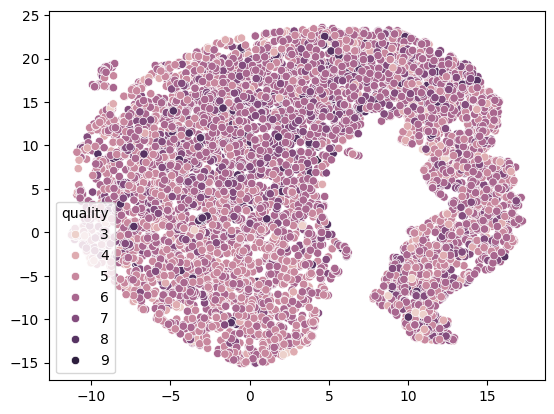

In [7]:
sb.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=y["quality"])

### Feature-similarity: saturation-mean

In [8]:
feature_similarity = "pH"
# feature_similarity = "intensity-mean"
labels = pd.Categorical(y["quality"]).codes

In [9]:
# Pairwise similarity for saturation-mean
connectivity_saturation_pairwise = np.float16(
    pairwise_distances(X.loc[:, [feature_similarity]], metric="manhattan")
)

# connectivity_saturation_pairwise = MinMaxScaler().fit_transform(
#     connectivity_saturation_pairwise
# )
connectivity_saturation_pairwise = np.round(connectivity_saturation_pairwise, 3)

# sb.histplot(connectivity_saturation_pairwise.flatten(), bins=100)

<Axes: ylabel='Count'>

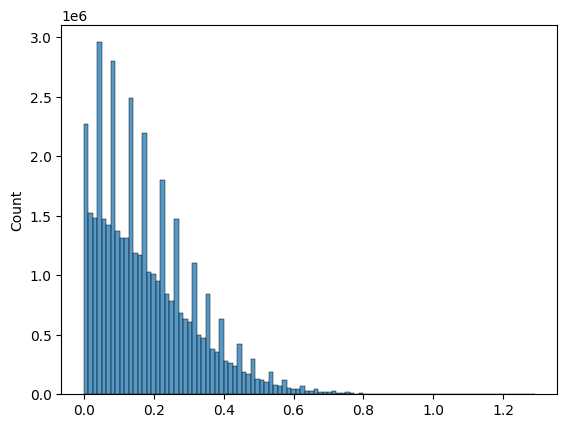

In [10]:
sb.histplot(connectivity_saturation_pairwise.flatten(), bins=100)

In [12]:
# kNN for feature_similarity
connectivity_saturation_knn = kneighbors_graph(
    X.loc[:, [feature_similarity]], n_neighbors=3, mode="distance"
)

graph_saturation_knn = nx.Graph(connectivity_saturation_knn)
edge_weights_saturation_knn_pairwise = []
for edge in graph_saturation_knn.edges():
    edge_weights_saturation_knn_pairwise.append(
        connectivity_saturation_pairwise[edge[0]][edge[1]]
    )

### Display Connectivity-Graphs

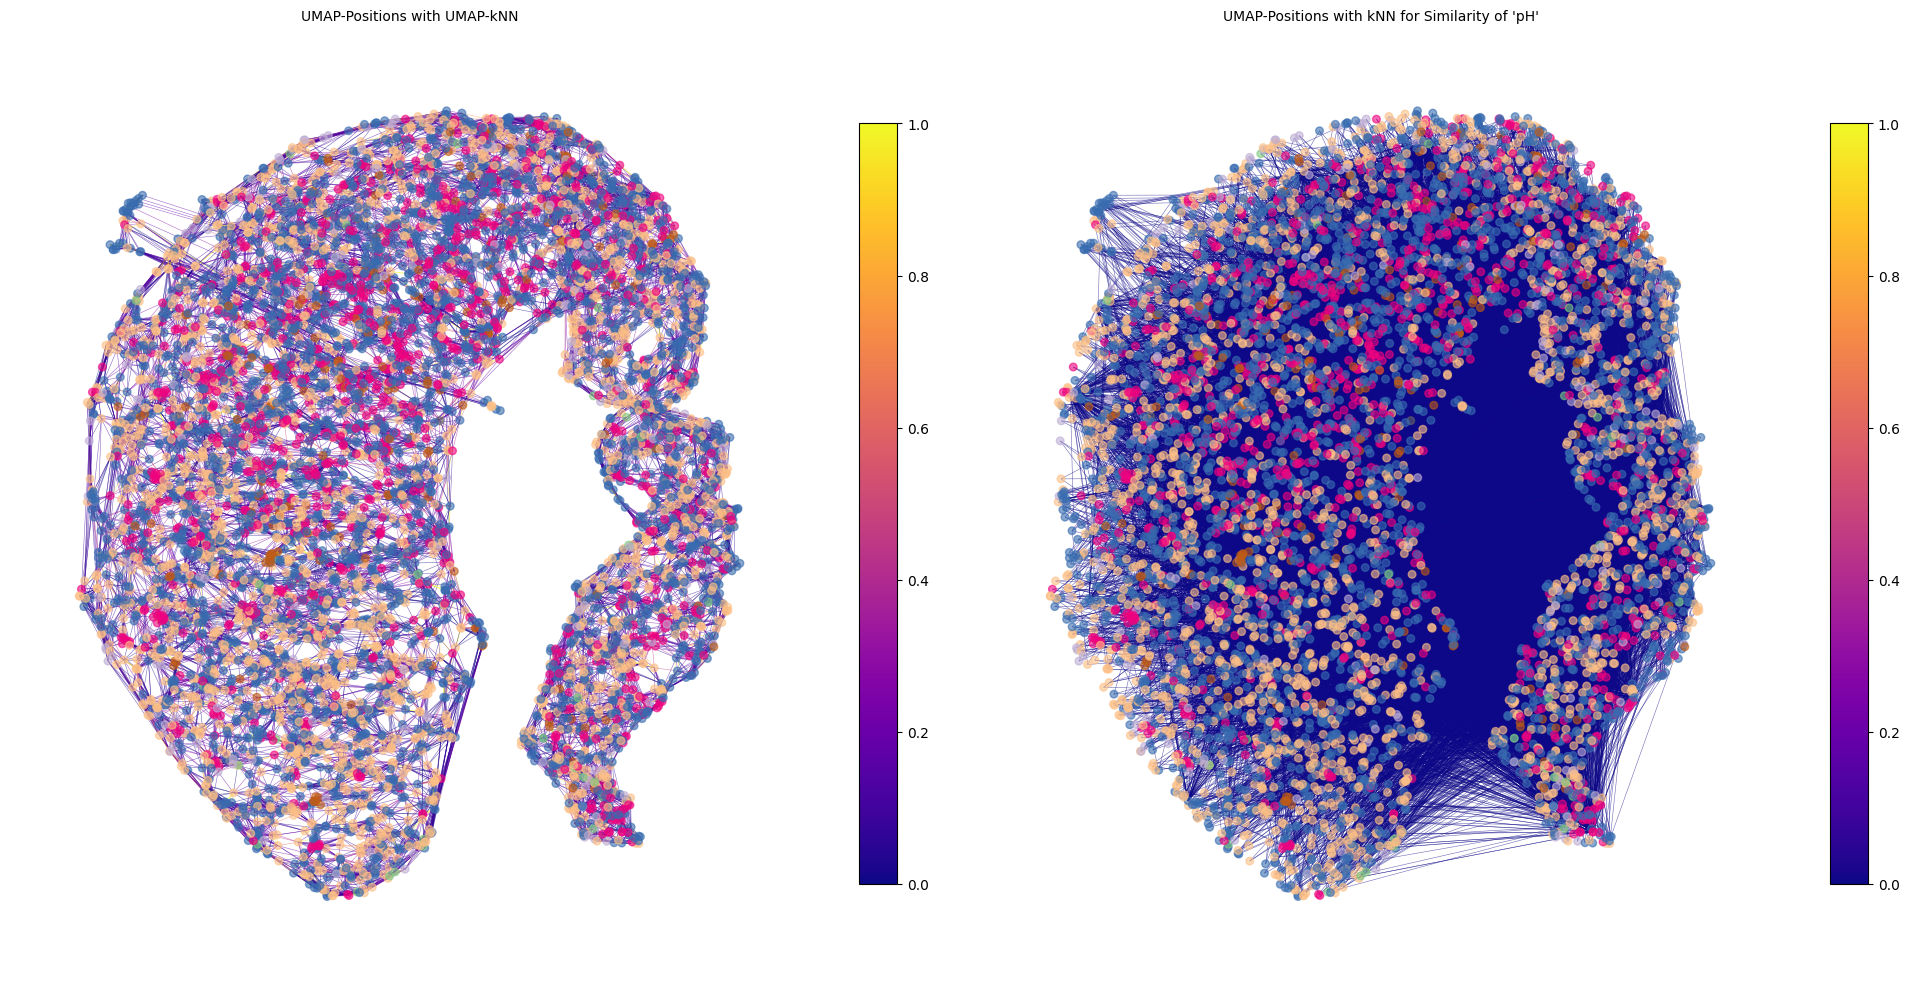

In [13]:
visualization.display_graphs(
    [
        (
            "UMAP-Positions with UMAP-kNN",
            graph_umap_knn,
            edge_weights_umap_knn,
            umap_embedding,
        ),
        (
            f"UMAP-Positions with kNN for Similarity of '{feature_similarity}'",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            umap_embedding,
        ),
    ],
    2,
    labels=labels,
    figsize=(20, 10),
)

### Force-directed exploration

In [14]:
umap_embedding_dict = {i: umap_embedding[i] for i in range(len(umap_embedding))}

In [15]:
pos_saturation_pairwise_08_force_it1 = nx.spring_layout(
    graph_saturation_knn,
    pos=umap_embedding_dict,
    iterations=1,
    threshold=0.0001,
)
pos_saturation_pairwise_08_force_it3 = nx.spring_layout(
    graph_saturation_knn,
    pos=umap_embedding_dict,
    iterations=3,
    threshold=0.0001,
)
pos_saturation_pairwise_08_force_it5 = nx.spring_layout(
    graph_saturation_knn,
    pos=umap_embedding_dict,
    iterations=5,
    threshold=0.0001,
)

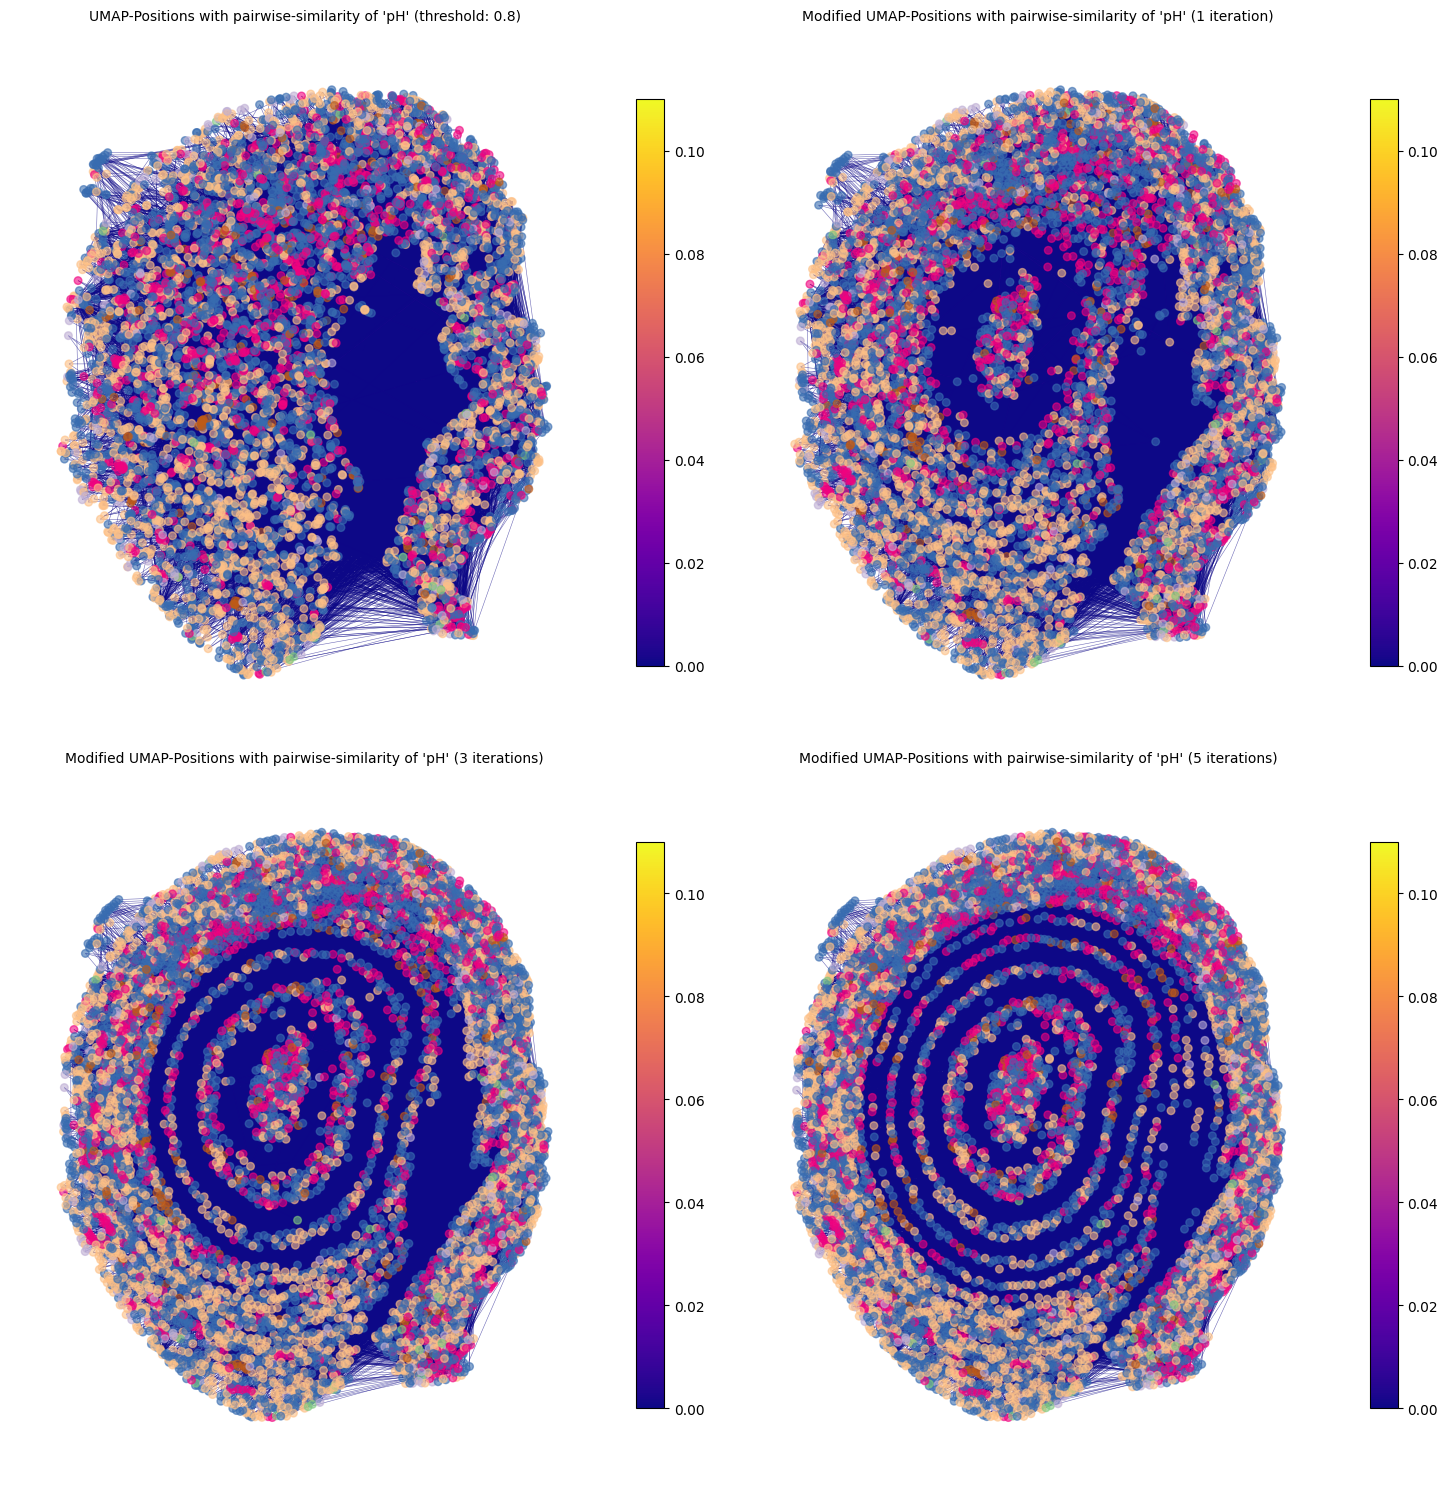

In [16]:
visualization.display_graphs(
    [
        (
            f"UMAP-Positions with pairwise-similarity of '{feature_similarity}' (threshold: 0.8)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            umap_embedding,
        ),
        (
            f"Modified UMAP-Positions with pairwise-similarity of '{feature_similarity}' (1 iteration)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            pos_saturation_pairwise_08_force_it1,
        ),
        (
            f"Modified UMAP-Positions with pairwise-similarity of '{feature_similarity}' (3 iterations)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            pos_saturation_pairwise_08_force_it3,
        ),
        (
            f"Modified UMAP-Positions with pairwise-similarity of '{feature_similarity}' (5 iterations)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            pos_saturation_pairwise_08_force_it5,
        ),
    ],
    2,
    labels=labels,
)

## Evaluation-exploration

### Shepard Diagram

In [17]:
pos_saturation_pairwise_08_force_test = nx.spring_layout(
    graph_saturation_knn,
    pos=umap_embedding_dict,
    # fixed=isolated_nodes if len(isolated_nodes) > 0 else None,
    iterations=13,
    threshold=0.0001,
)

In [ ]:
# feature_similarity_values = np.float16(X[feature_similarity].values.reshape(-1, 1))

# similarities_highdim = evaluation.compute_distance_matrix(feature_similarity_values)
# similarities_lowdim = evaluation.compute_distance_matrix(umap_embedding)

# scaler = MinMaxScaler()
# similarities_highdim = scaler.fit_transform(
#     similarities_highdim.reshape(-1, 1)
# ).flatten()
# similarities_lowdim = scaler.fit_transform(similarities_lowdim.reshape(-1, 1)).flatten()

# evaluation.plot_shepard_diagram(
#     similarities_lowdim, similarities_highdim, feature_similarity
# )

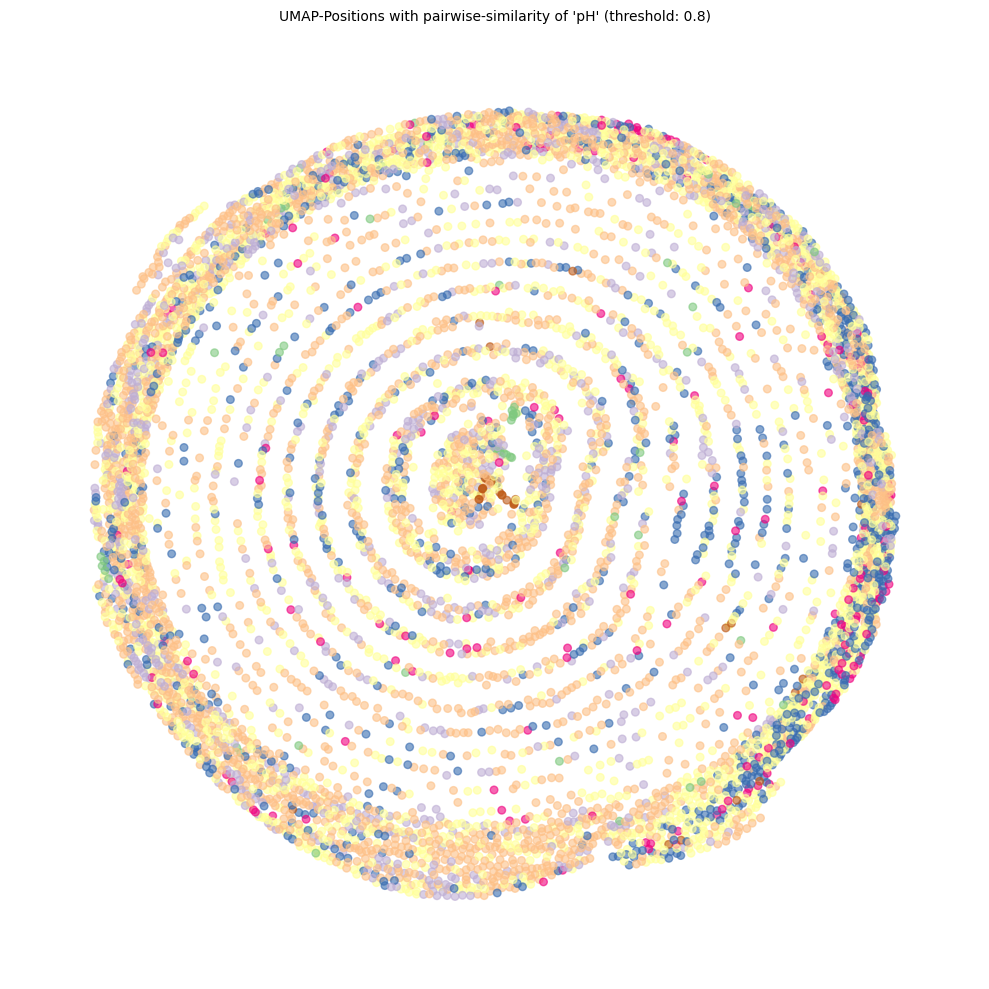

In [19]:
visualization.display_graphs(
    [
        (
            f"UMAP-Positions with pairwise-similarity of '{feature_similarity}' (threshold: 0.8)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            pos_saturation_pairwise_08_force_test,
        ),
    ],
    1,
    labels=X["pH"],
    show_cbar=False,
    figsize=(10, 10),
    show_edges=False,
)

In [20]:
graph_coordinates = np.array(
    [x for x in pos_saturation_pairwise_08_force_test.values()]
)
similarities_lowdim = evaluation.compute_distance_matrix(graph_coordinates)

scaler = MinMaxScaler()
similarities_lowdim = scaler.fit_transform(similarities_lowdim.reshape(-1, 1)).flatten()

# evaluation.plot_shepard_diagram(
#     similarities_lowdim, similarities_highdim, feature_similarity
# )

### pyDRMetrics

In [ ]:
# evaluation.pydrmetrics_report(X, umap_embedding)

KeyboardInterrupt: 

In [ ]:
# evaluation.pydrmetrics_plot_coranking_matrix(X, umap_embedding)

MemoryError: Unable to allocate 322. MiB for an array with shape (6497, 6497) and data type float64

### Neighborhood-Preservation

In [21]:
accuracies = evaluation.compute_jaccard_distances(
    umap_mapper, umap_embedding, nhood_size=15
)
accuracies

array([0.5       , 0.15384615, 0.25      , ..., 0.30434783, 0.36363636,
       0.25      ])

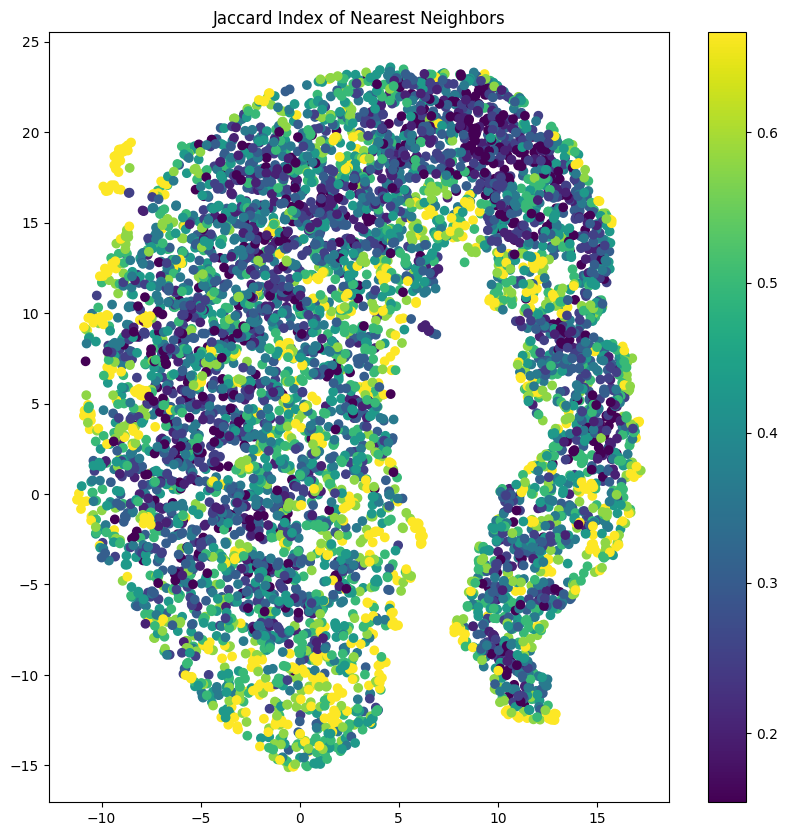

In [22]:
fig = plt.figure(figsize=(10, 10))
vmin = np.percentile(accuracies, 5)
vmax = np.percentile(accuracies, 95)

plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=accuracies,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar()
plt.title("Jaccard Index of Nearest Neighbors")
plt.show()

<Axes: title={'center': 'Colored by neighborhood Jaccard index'}>

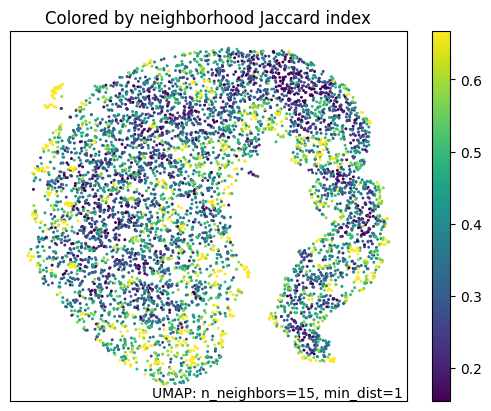

In [ ]:
umap.plot.diagnostic(umap_mapper, diagnostic_type="neighborhood", nhood_size=15)

### Sequence Difference View

In [ ]:
# np_array = np.load("../../data/interim/results_20250323-115451.npy", allow_pickle=True)

In [ ]:
sequence_diff_initial = evaluation.compute_sequence_diff(
    umap_mapper._raw_data, np.array(umap_embedding), nhood_size=7
)

fig = plt.figure(figsize=(7, 7))
vmin = np.percentile(sequence_diff_initial, 5)
vmax = np.percentile(sequence_diff_initial, 95)

plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=sequence_diff_initial,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar()
plt.title("Sequence Difference View (initial embedding)")
plt.show()


In [24]:
sequence_diff_initial = evaluation.compute_sequence_diff(
    umap_mapper._raw_data, np.array(umap_embedding), nhood_size=7
)

pos_saturation_pairwise_08_force_it1_diff = evaluation.compute_sequence_diff(
    umap_mapper._raw_data,
    np.array(list(pos_saturation_pairwise_08_force_it1.values())),
    nhood_size=7,
)
pos_saturation_pairwise_08_force_it3_diff = evaluation.compute_sequence_diff(
    umap_mapper._raw_data,
    np.array(list(pos_saturation_pairwise_08_force_it3.values())),
    nhood_size=7,
)
pos_saturation_pairwise_08_force_it5_diff = evaluation.compute_sequence_diff(
    umap_mapper._raw_data,
    np.array(list(pos_saturation_pairwise_08_force_it5.values())),
    nhood_size=7,
)

In [25]:
sequence_changes = np.zeros([umap_mapper._raw_data.shape[0]])
sequence_changes = np.vstack(
    [
        sequence_changes,
        evaluation.compute_sequence_change(
            sequence_diff_initial, pos_saturation_pairwise_08_force_it1_diff
        ),
    ]
)
sequence_changes = np.vstack(
    [
        sequence_changes,
        evaluation.compute_sequence_change(
            sequence_diff_initial, pos_saturation_pairwise_08_force_it3_diff
        ),
    ]
)
sequence_changes = np.vstack(
    [
        sequence_changes,
        evaluation.compute_sequence_change(
            sequence_diff_initial, pos_saturation_pairwise_08_force_it5_diff
        ),
    ]
)

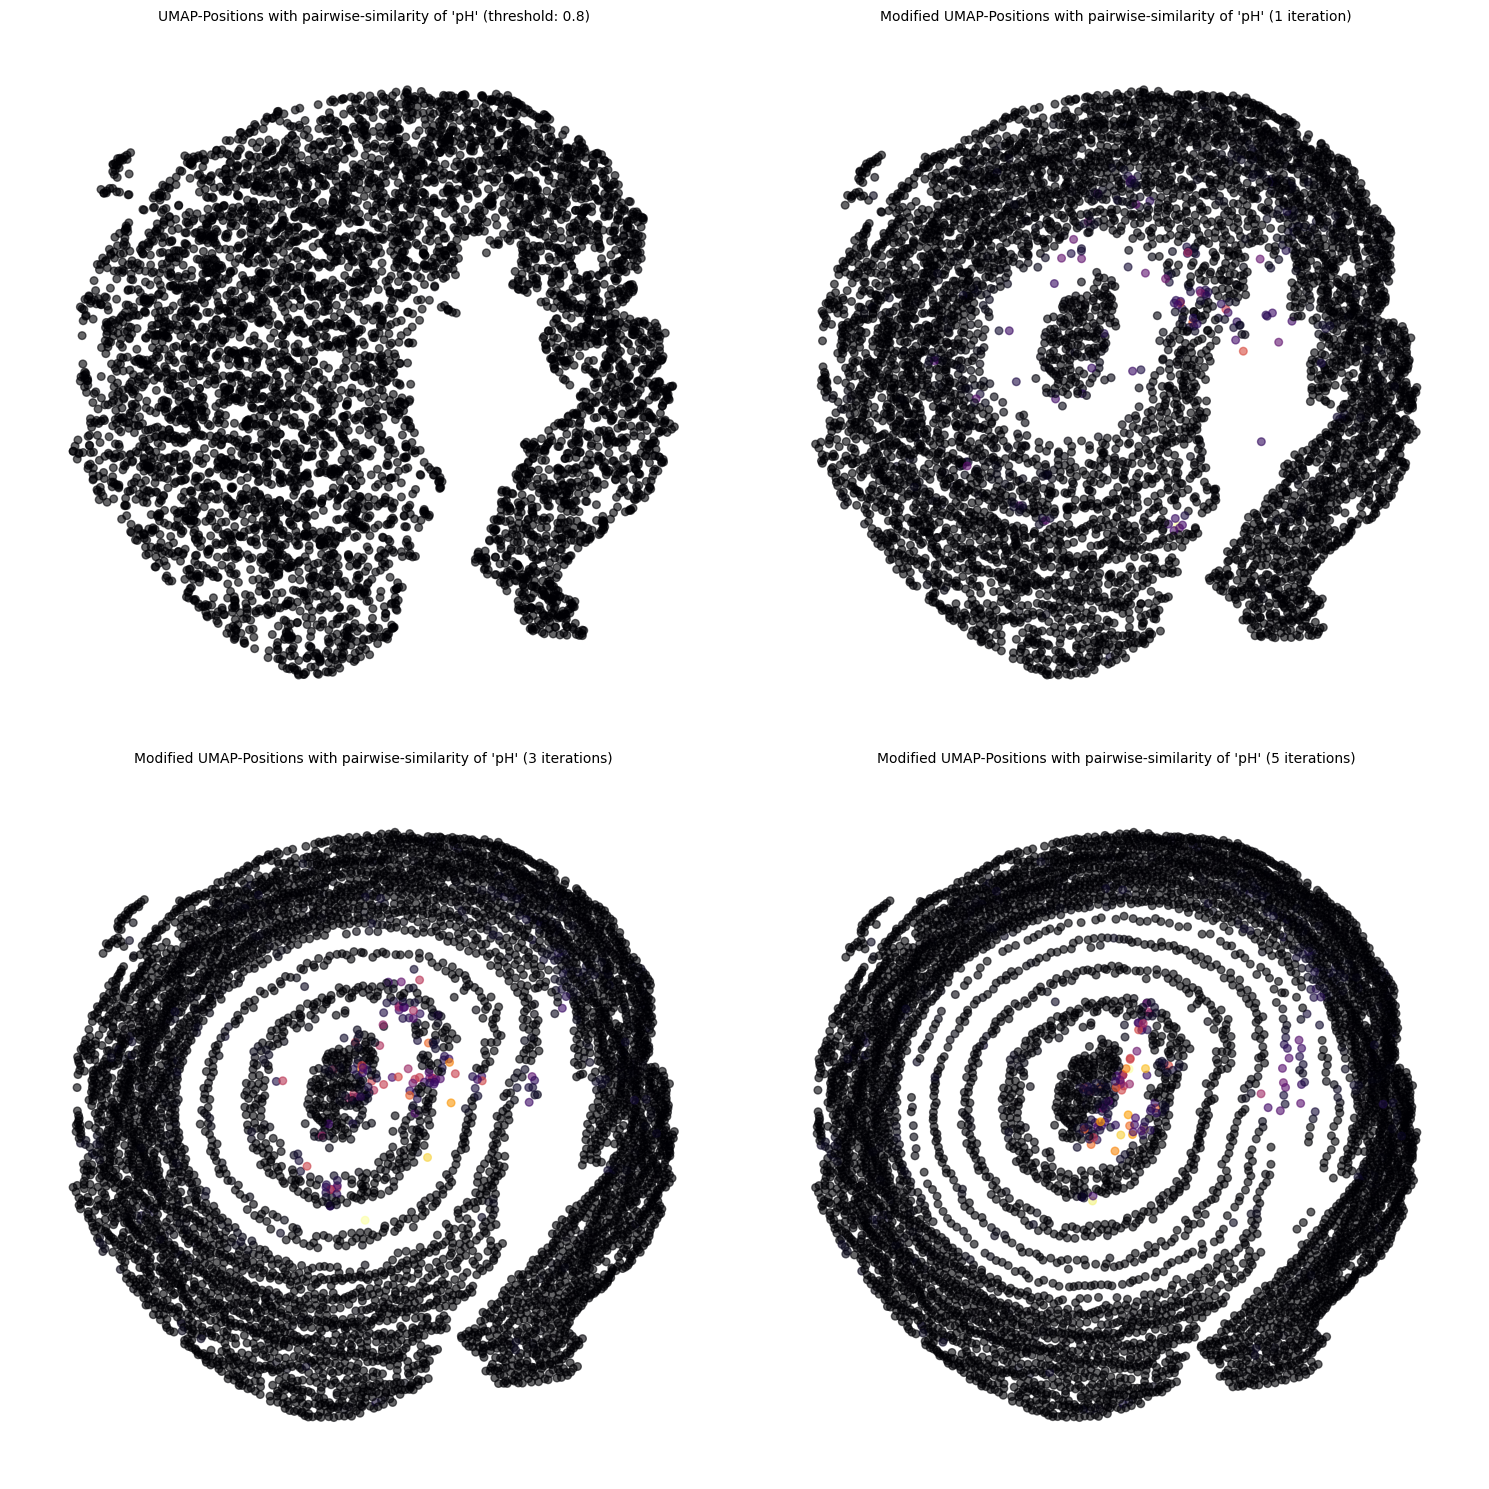

In [34]:
visualization.display_graphs(
    [
        (
            f"UMAP-Positions with pairwise-similarity of '{feature_similarity}' (threshold: 0.8)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            umap_embedding,
        ),
        (
            f"Modified UMAP-Positions with pairwise-similarity of '{feature_similarity}' (1 iteration)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            pos_saturation_pairwise_08_force_it1,
        ),
        (
            f"Modified UMAP-Positions with pairwise-similarity of '{feature_similarity}' (3 iterations)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            pos_saturation_pairwise_08_force_it3,
        ),
        (
            f"Modified UMAP-Positions with pairwise-similarity of '{feature_similarity}' (5 iterations)",
            graph_saturation_knn,
            edge_weights_saturation_knn_pairwise,
            pos_saturation_pairwise_08_force_it5,
        ),
    ],
    2,
    labels=sequence_changes,
    cmap=plt.cm.inferno,
    show_cbar=False,
    show_edges=False,
)

## Dash-Exploration

In [26]:
dash_df_list = [
    pd.DataFrame(
        {
            "x": umap_embedding[:, 0],
            "y": umap_embedding[:, 1],
            "metrics_score": sequence_changes[0],
        }
    )
]

iterations = [
    pos_saturation_pairwise_08_force_it1,
    pos_saturation_pairwise_08_force_it3,
    pos_saturation_pairwise_08_force_it5,
]

for i, it in enumerate(iterations):
    it_transposed = pd.DataFrame(it).T
    dash_df_list.append(
        pd.DataFrame(
            {
                "x": it_transposed.iloc[:, 0],
                "y": it_transposed.iloc[:, 1],
                "metrics_score": sequence_changes[i + 1],
            }
        )
    )

In [ ]:
# dash_df_list = [
#     pd.DataFrame(
#         {
#             "x": umap_embedding[:, 0],
#             "y": umap_embedding[:, 1],
#             "metrics_score": sequence_changes[0],
#         }
#     )
# ]

# iterations = [
#     pos_saturation_pairwise_08_force_it1,
#     pos_saturation_pairwise_08_force_it3,
#     pos_saturation_pairwise_08_force_it5,
# ]

# for i, it in enumerate(iterations):
#     it_transposed = pd.DataFrame(it).T
#     dash_df_list.append(
#         pd.DataFrame(
#             {
#                 "x": it_transposed.iloc[:, 0],
#                 "y": it_transposed.iloc[:, 1],
#                 "metrics_score": sequence_changes[i + 1],
#             }
#         )
#     )

In [27]:
save_results(dash_df_list)

In [29]:
np_array = np.load("../../data/interim/results_20250323-141832.npy", allow_pickle=True)
dash_df_list = []
for i in range(len(np_array)):
    dash_df_list.append(pd.DataFrame(np_array[i], columns=["x", "y", "metrics_score"]))

In [30]:
dash_app = DashOverlay(dash_df_list, [0, 1, 3, 5])

In [31]:
dash_app.run()